In [1]:
from libraries import *

/media/boris/F/anaconda3/envs/nemo/lib/python3.9/site-packages/apex/pyprof/__init__.py:5: FutureWarning: pyprof will be removed by the end of June, 2022
  warnings.warn("pyprof will be removed by the end of June, 2022", FutureWarning)
################################################################################
### WARNING, path does not exist: KALDI_ROOT=media/boris/F/pykaldi/kaldi
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################

[NeMo W 2022-04-24 08:26:02 experimental:27] Module <class 'nemo.collections.nlp.data.language_modeling.megatron.megatron_batch_samplers.MegatronPretrainingRandomBatchSampler'> is experimental, not ready for production and is not fully supported. Use at your own risk.


In [2]:
from models import asr_model, spec_gen, vocoder
from transfer_modules import *

[NeMo E 2022-04-24 08:26:04 vocabs:324] Torch distributed needs to be initialized before you initialized <nemo.collections.common.data.vocabs.Phonemes object at 0x7f69e84afbb0>. This class is prone to data access race conditions. Now downloading corpora from global rank 0. If other ranks pass this before rank 0, errors might result.
[NeMo E 2022-04-24 08:26:05 vocabs:324] Torch distributed needs to be initialized before you initialized <nemo.collections.common.data.vocabs.Phonemes object at 0x7f69c4db6610>. This class is prone to data access race conditions. Now downloading corpora from global rank 0. If other ranks pass this before rank 0, errors might result.
[NeMo E 2022-04-24 08:26:07 vocabs:324] Torch distributed needs to be initialized before you initialized <nemo.collections.common.data.vocabs.Phonemes object at 0x7f69bb651550>. This class is prone to data access race conditions. Now downloading corpora from global rank 0. If other ranks pass this before rank 0, errors might res

In [3]:
from datetime import datetime


In [4]:
models = [asr_model, spec_gen, vocoder]

asr_model.cuda()
spec_gen.cuda()
vocoder.cuda(1)

# for model in models:
#     model.cuda()

HifiGanModel(
  (audio_to_melspec_precessor): FilterbankFeatures()
  (trg_melspec_fn): FilterbankFeatures()
  (generator): Generator(
    (conv_pre): Conv1d(80, 512, kernel_size=(7,), stride=(1,), padding=(3,))
    (ups): ModuleList(
      (0): ConvTranspose1d(512, 256, kernel_size=(16,), stride=(8,), padding=(4,))
      (1): ConvTranspose1d(256, 128, kernel_size=(16,), stride=(8,), padding=(4,))
      (2): ConvTranspose1d(128, 64, kernel_size=(4,), stride=(2,), padding=(1,))
      (3): ConvTranspose1d(64, 32, kernel_size=(4,), stride=(2,), padding=(1,))
    )
    (resblocks): ModuleList(
      (0): ModuleList(
        (0): ResBlock1(
          (convs1): ModuleList(
            (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
            (1): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(3,), dilation=(3,))
            (2): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(5,), dilation=(5,))
          )
          (convs2): ModuleList(
            (0

In [5]:
# from nemo.collections.tts.modules.hifigan_modules import MultiPeriodDiscriminator, MultiScaleDiscriminator

# vocoder.mpd = MultiPeriodDiscriminator(debug=True).cuda(1)
# vocoder.msd = MultiScaleDiscriminator(debug=True).cuda(1)

In [6]:
max_epochs = 1000
dataloader_idx = 0
overall_loss = []
validate_asr = True
validate_spec_gen = True

In [7]:
on_train_start(models)

In [ ]:
res = []
wer = []
spec_gen_loss = []

dt = True

# progress_bar = tqdm(range(int(10e6)))

for epoch in range(max_epochs + 1):
#     print('epoch start', epoch)
    epoch_loss = []
    
    on_epoch_start(models)
    
#     if epoch > 80:
#         dt = True
    
    for batch_idx, (asr_batch, tts_batch, raw_signal_batch, raw_text_batch) in \
       tqdm(enumerate(zip(asr_model.train_dataloader(), spec_gen.train_dataloader(), 
                     asr_model.val_dataloader(), spec_gen.val_dataloader()))):
                
        asr_loss, fastpitch_loss, hifigan_loss = 0, 0, 0
                            
        asr_loss = asr_training_step(
            asr_model, spec_gen, vocoder, asr_batch, raw_signal_batch, batch_idx, epoch=epoch, dt=dt)
        
        fastpitch_loss, hifigan_loss = tts_training_step(
            asr_model, spec_gen, vocoder, tts_batch, raw_signal_batch, batch_idx, epoch=epoch, dt=dt)
        
#     print(asr_loss, fastpitch_loss, hifigan_loss, datetime.now())
        
        epoch_loss.append([asr_loss, fastpitch_loss, hifigan_loss])
    
    on_epoch_end(models)
    epoch_loss = np.array(epoch_loss)
    res.append([epoch, np.mean(epoch_loss[:, 0]), np.mean(epoch_loss[:, 1]), np.mean(epoch_loss[:, 2])])
    
    if validate_asr and (epoch % 5 == 0):
        train_wer = asr_val(asr_model, asr_model.train_dataloader())
        val_wer = asr_val(asr_model, asr_model.val_dataloader())
        wer.append([epoch, train_wer, val_wer])
        print(epoch, 'wer', train_wer, val_wer, datetime.now())
    
    if validate_spec_gen and (epoch % 5 == 0):
        spec_gen_train_loss = tts_val(spec_gen, spec_gen.train_dataloader())
        spec_gen_val_loss = tts_val(spec_gen, spec_gen.val_dataloader())
        spec_gen_loss.append([epoch, spec_gen_train_loss, spec_gen_val_loss])
        print(epoch, 'spec_gen loss', spec_gen_train_loss, spec_gen_val_loss, datetime.now())
    
    print(epoch, 'loss', np.mean(epoch_loss[:, 0]), np.mean(epoch_loss[:, 1]), np.mean(epoch_loss[:, 2]))
    
    
on_train_end(models)

878it [09:17,  1.57it/s]


0 wer tensor(0.9800) tensor(0.9823) 2022-04-24 08:37:59.905305
0 spec_gen loss 0.4555729 0.66293705 2022-04-24 08:38:29.505251
0 loss 187.7371818481654 154.06333928553553 0.0


878it [09:18,  1.57it/s]


1 loss 121.14271345659921 153.58793478077257 0.0


878it [09:20,  1.57it/s]


2 loss 119.79229814316525 153.5005248510756 0.0


878it [09:18,  1.57it/s]


3 loss 118.91399307620281 153.40493515466503 0.0


878it [09:19,  1.57it/s]


4 loss 118.64181454903986 153.41484197994572 0.0


878it [09:21,  1.56it/s]


5 wer tensor(0.9667) tensor(0.9712) 2022-04-24 09:26:27.957774
5 spec_gen loss 0.42933086 0.6518762 2022-04-24 09:26:57.370262
5 loss 117.1473540504864 153.6545108021799 0.0


878it [09:21,  1.56it/s]


6 loss 117.15718090561364 153.39484135273648 0.0


878it [09:19,  1.57it/s]


7 loss 117.31755146350295 153.3483250950355 0.0


878it [09:21,  1.56it/s]


8 loss 130.04271334776303 153.33792536133785 0.0


878it [09:19,  1.57it/s]


9 loss 116.97417375004102 153.25639545292952 0.0


878it [09:19,  1.57it/s]


10 wer tensor(0.9406) tensor(0.9442) 2022-04-24 10:14:59.738330
10 spec_gen loss 0.34588104 0.6118968 2022-04-24 10:15:29.387575
10 loss 132.17632460648485 153.49616151084118 0.0


878it [09:18,  1.57it/s]


11 loss 130.35137150445127 153.30376435195123 0.0


878it [09:15,  1.58it/s]


12 loss 130.552882796268 153.24083094499105 0.0


878it [09:19,  1.57it/s]


13 loss 153.36308611281098 153.25625657274946 0.0


878it [09:15,  1.58it/s]


14 loss 199.707096234541 153.1268326883164 0.0


878it [09:20,  1.57it/s]


15 wer tensor(0.9593) tensor(0.9640) 2022-04-24 11:03:18.797497
15 spec_gen loss 0.32961282 0.63557357 2022-04-24 11:03:48.227748
15 loss 187.31439446425384 153.25696187464686 0.0


878it [09:21,  1.56it/s]


16 loss 278.8540165896839 153.37639060487507 0.0


878it [09:26,  1.55it/s]


17 loss 629.6039316040508 153.1256890698826 0.0


878it [09:28,  1.55it/s]


18 loss 845.17476617774 152.97628258246766 0.0


878it [09:28,  1.54it/s]


19 loss 787.2844222922531 151.72007689334808 0.0


878it [09:27,  1.55it/s]


20 wer tensor(0.9828) tensor(0.9744) 2022-04-24 11:52:19.433387
20 spec_gen loss 0.26565212 0.6356371 2022-04-24 11:52:49.068511
20 loss 446.22820888727836 152.91319071567682 0.0


878it [09:25,  1.55it/s]


21 loss 504.8007220765724 152.9214792142968 0.0


878it [09:28,  1.55it/s]


22 loss 288.5296814935897 152.79203923253644 0.0


878it [09:28,  1.54it/s]


23 loss 377.29549615855643 152.98351933038316 0.0


2it [00:01,  1.49it/s]

In [9]:
fastpitch_loss

0

In [8]:
for batch in spec_gen.train_dataloader():
    print(batch[0])
    _, _, parsed, _, _, _, _ = batch
    parsed = parsed.cuda(0)
    
    print(parsed)
    
    mels_pred = spec_gen.generate_spectrogram(tokens=parsed)
    signal = vocoder.convert_spectrogram_to_audio(spec=mels_pred.cuda(1))
    signal_len = torch.tensor([len(signal[0])])
    
    break

tensor([[ 0.0002,  0.0002,  0.0003,  ..., -0.0009, -0.0009, -0.0009]])
tensor([[ 0, 84, 87,  0, 89, 84,  0, 84, 83, 74,  0, 53, 12,  3, 31, 16, 18, 15,
         55, 97,  0, 84, 87,  0, 89, 84,  0, 70, 83,  0, 54, 12,  3, 31, 20, 53,
          8, 31, 21, 31, 10,  0, 14, 15, 41, 20, 31, 18,  0, 27,  9, 22, 31, 14,
         50, 17, 31, 12, 98,  0]], device='cuda:0')


In [18]:
from datetime import datetime

print(datetime.now())

2022-04-03 17:55:39.647139


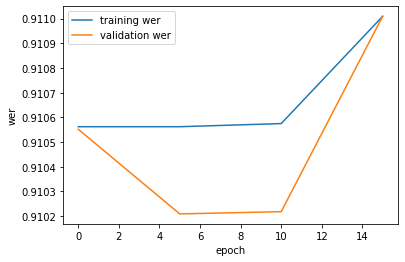

In [8]:
epoch = []
train_wer = []
val_wer = []

for item in wer:
    epoch.append(item[0])
    train_wer.append(item[1])
    val_wer.append(item[2])
    
plt.plot(epoch, train_wer, label='training wer')
plt.plot(epoch, val_wer, label='validation wer')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('wer')

plt.show()

In [29]:
epoch

[0,
 5,
 10,
 15,
 20,
 25,
 30,
 35,
 40,
 45,
 50,
 55,
 60,
 65,
 70,
 75,
 80,
 85,
 90,
 95,
 100,
 105,
 110,
 115,
 120,
 125,
 130,
 135,
 140,
 145,
 150,
 155,
 160,
 165,
 170]

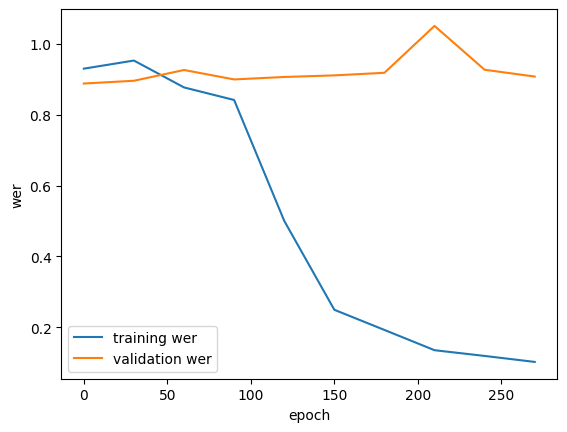

In [30]:
epoch2 = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270]
train_wer2 = [0.9302, 0.9531, 0.8772, 0.8417, 0.5004, 0.2492, 0.1922, 0.1350, 0.1188, 0.1019]
val_wer2 = [0.8882, 0.8960, 0.9264, 0.8998, 0.9067, 0.9112, 0.9185, 1.0509, 0.9271, 0.9079]
    
plt.plot(epoch2, train_wer2, label='training wer')
plt.plot(epoch2, val_wer2, label='validation wer')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('wer')

plt.show()

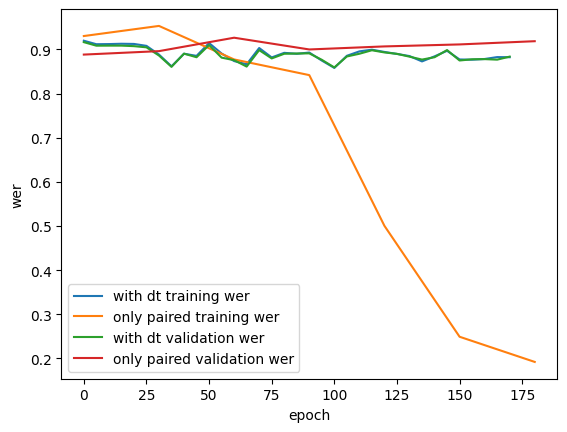

In [33]:
epoch2 = [0, 30, 60, 90, 120, 150, 180]
train_wer2 = [0.9302, 0.9531, 0.8772, 0.8417, 0.5004, 0.2492, 0.1922]
val_wer2 = [0.8882, 0.8960, 0.9264, 0.8998, 0.9067, 0.9112, 0.9185]

plt.plot(epoch, train_wer, label='with dt training wer')
plt.plot(epoch2, train_wer2, label='only paired training wer')
plt.plot(epoch, val_wer, label='with dt validation wer')
plt.plot(epoch2, val_wer2, label='only paired validation wer')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('wer')

plt.show()

In [27]:
wer

[[0, tensor(0.9196), tensor(0.9164)],
 [5, tensor(0.9117), tensor(0.9083)],
 [10, tensor(0.9120), tensor(0.9085)],
 [15, tensor(0.9127), tensor(0.9085)],
 [20, tensor(0.9123), tensor(0.9073)],
 [25, tensor(0.9080), tensor(0.9046)],
 [30, tensor(0.8882), tensor(0.8861)],
 [35, tensor(0.8616), tensor(0.8604)],
 [40, tensor(0.8902), tensor(0.8903)],
 [45, tensor(0.8852), tensor(0.8822)],
 [50, tensor(0.9143), tensor(0.9097)],
 [55, tensor(0.8906), tensor(0.8813)],
 [60, tensor(0.8735), tensor(0.8755)],
 [65, tensor(0.8662), tensor(0.8610)],
 [70, tensor(0.9031), tensor(0.8983)],
 [75, tensor(0.8817), tensor(0.8795)],
 [80, tensor(0.8922), tensor(0.8901)],
 [85, tensor(0.8900), tensor(0.8906)],
 [90, tensor(0.8928), tensor(0.8910)],
 [95, tensor(0.8747), tensor(0.8764)],
 [100, tensor(0.8580), tensor(0.8591)],
 [105, tensor(0.8854), tensor(0.8839)],
 [110, tensor(0.8954), tensor(0.8901)],
 [115, tensor(0.8993), tensor(0.8980)],
 [120, tensor(0.8942), tensor(0.8931)],
 [125, tensor(0.8897),

In [15]:
epoch

[]

In [8]:
train_wer = val(asr_model, asr_model.train_dataloader())
val_wer = val(asr_model, asr_model.val_dataloader())
wer.append([epoch, train_wer, val_wer])
print('wer', train_wer, val_wer)
print(epoch, 'loss', np.mean(epoch_loss[:, 0]), np.mean(epoch_loss[:, 1]), np.mean(epoch_loss[:, 2]))

13it [00:01, 10.68it/s]
1000it [01:04, 15.53it/s]

wer tensor(0.1019) tensor(0.9079)
249 loss 56.31022218557504 0.0 0.0


In [9]:
plt.plot(wer)
plt.show()

ValueError: setting an array element with a sequence.

In [15]:
epoch_loss

array([[106.80142212,   0.        ,   0.        ],
       [ 41.64225769,   0.        ,   0.        ],
       [ 61.18325806,   0.        ,   0.        ],
       [ 49.07572174,   0.        ,   0.        ],
       [ 30.47376442,   0.        ,   0.        ],
       [ 51.6505661 ,   0.        ,   0.        ],
       [ 36.35122681,   0.        ,   0.        ],
       [ 85.67857361,   0.        ,   0.        ],
       [ 69.47576904,   0.        ,   0.        ],
       [ 38.40878296,   0.        ,   0.        ],
       [ 39.13494873,   0.        ,   0.        ],
       [ 53.32878494,   0.        ,   0.        ],
       [ 68.82781219,   0.        ,   0.        ]])

In [30]:
asr_model.save_to('asr_model_60_epoch.nemo')
# spec_gen.save_to('spe_gen.nemo')
# vocoder.save_to('vocoder.nemo')

In [ ]:
spec_gen.save_to('spe_gen.nemo')

In [22]:
config_path = 'stt_en_citrinet_256_gamma_0_25'
config_name = 'model_config.yaml'
yaml = YAML(typ='safe')

with open(os.path.join(config_path, config_name)) as f:
    config = yaml.load(f)

config['tokenizer']['dir'] = 'citrinet_tokenizer/tokenizer_spe_unigram_v1024'
config['tokenizer']['type'] = 'bpe'

config['train_ds']['manifest_filepath']="../../datasets/LJSpeech-1.1/small_manifest.json"
# config['train_ds']['manifest_filepath']="../../datasets/an4/train_manifest.json"
config['train_ds']['batch_size'] = 1
config['train_ds']['num_workers'] = 12
config['train_ds']['pin_memory'] = True

config['validation_ds']['manifest_filepath']="../../datasets/LJSpeech-1.1/train_manifest.json"
# config['validation_ds']['manifest_filepath']="../../datasets/an4/test_manifest.json"
config['validation_ds']['batch_size'] = 1
config['validation_ds']['num_workers'] = 12
config['validation_ds']['pin_memory'] = True

config['tokenizer']['model_path'] = 'stt_en_citrinet_256_gamma_0_25/3d20ebb793c84a64a20c7ad26fc64d62_tokenizer.model'
config['tokenizer']['vocab_path'] = 'stt_en_citrinet_256_gamma_0_25/df5191f216004f10a268c44e90fdb63f_vocab.txt'
config['tokenizer']['spe_tokenizer_vocab'] = 'stt_en_citrinet_256_gamma_0_25/b774eaac83804907843607272fde21a4_tokenizer.vocab'

config['init_from_nemo_model'] = 'asr_model.nemo'

qqq = nemo_asr.models.EncDecCTCModelBPE(cfg=DictConfig(config))
qqq.maybe_init_from_pretrained_checkpoint(cfg=DictConfig(config))

In [4]:
asr_model = nemo_asr.models.EncDecCTCModelBPE.restore_from(restore_path='asr_model.nemo')

In [5]:
spec_gen = FastPitchModel.restore_from(restore_path='spe_gen.nemo')

[NeMo E 2022-02-09 16:15:39 vocabs:324] Torch distributed needs to be initialized before you initialized <nemo.collections.asr.data.vocabs.Phonemes object at 0x7fe300513fd0>. This class is prone to data access race conditions. Now downloading corpora from global rank 0. If other ranks pass this before rank 0, errors might result.


In [3]:
vocoder = HifiGanModel.restore_from(restore_path="vocoder.nemo")


In [7]:
trainer = pl.Trainer(max_epochs=200, gpus=1, limit_val_batches=0)

trainer.fit(asr_model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name              | Type                              | Params
------------------------------------------------------------------------
0 | preprocessor      | AudioToMelSpectrogramPreprocessor | 0     
1 | encoder           | ConvASREncoder                    | 9.1 M 
2 | decoder           | ConvASRDecoder                    | 657 K 
3 | loss              | CTCLoss                           | 0     
4 | spec_augmentation | SpectrogramAugmentation           | 0     
5 | _wer              | WERBPE                            | 0     
------------------------------------------------------------------------
9.8 M     Trainable params
0         Non-trainable params
9.8 M     Total params
39.145    Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

In [20]:
def val(model, dataloader):
    torch.set_grad_enabled(False)
    model.on_validation_start()
    model.on_epoch_start()
    model.on_validation_epoch_start()

    val_outs = []

    for batch_idx, val_batch in enumerate(dataloader):

        model.on_validation_batch_start(val_batch, batch_idx, 0)

        batch = model.on_before_batch_transfer(val_batch, 0)
        batch = model.transfer_batch_to_device(batch, torch.device('cuda'), 0)
        batch = model.on_after_batch_transfer(batch, 0)

        out = model.cuda().validation_step(batch, batch_idx)

        val_loss, val_wer_num, val_wer_denom, val_wer = out
        
        model.on_validation_batch_end(out, batch, batch_idx, 0)
        val_outs.append(out)
        
    model.on_epoch_end()
    model.on_validation_end()

    torch.set_grad_enabled(True)
    
    val_wer = []
    for item in val_outs:
        val_wer.append(item['val_wer'])

    return torch.mean(torch.tensor(val_wer))

In [18]:
train_wer = val(asr_model, asr_model.train_dataloader())
val_wer = val(asr_model, asr_model.val_dataloader())

In [19]:
train_wer, val_wer

(tensor(3.3656), tensor(3.5458))

In [6]:
for outs in val_outs:
    val_wer = []
    for item in outs:
        val_wer.append(item['val_wer'])

    print(torch.mean(torch.tensor(val_wer)))

NameError: name 'val_outs' is not defined

In [14]:
def tts_val(model, dataloader):
    
    losses = []
    
    for batch_idx, batch in tqdm(enumerate(dataloader)):
        
        model.on_validation_batch_start(batch, batch_idx, 0)

        batch = model.on_before_batch_transfer(batch, 0)
        batch = model.transfer_batch_to_device(batch, torch.device('cuda'), 0)
        batch = model.on_after_batch_transfer(batch, 0)
        
        out = model.validation_step(batch, batch_idx)

        model.on_validation_batch_end(out, batch, batch_idx, 0)
        
        losses.append(out['val_loss'].cpu().detach().numpy())
    return np.mean(losses)

In [15]:
tts_val(spec_gen, spec_gen.train_dataloader())

199it [00:05, 39.74it/s]


17.508982

In [10]:
asr_model.transcribe(['../../datasets//LJSpeech-1.1/wavs/LJ015-0247.wav',
                     '../../datasets//LJSpeech-1.1/wavs/LJ028-0475.wav'
                     ])

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

['⁇ ssss ⁇', '⁇ sss ⁇']

In [11]:
vocoder = HifiGanModel.from_pretrained("tts_hifigan")

In [12]:
vocoder.cuda(1)

HifiGanModel(
  (audio_to_melspec_precessor): FilterbankFeatures()
  (trg_melspec_fn): FilterbankFeatures()
  (generator): Generator(
    (conv_pre): Conv1d(80, 512, kernel_size=(7,), stride=(1,), padding=(3,))
    (ups): ModuleList(
      (0): ConvTranspose1d(512, 256, kernel_size=(16,), stride=(8,), padding=(4,))
      (1): ConvTranspose1d(256, 128, kernel_size=(16,), stride=(8,), padding=(4,))
      (2): ConvTranspose1d(128, 64, kernel_size=(4,), stride=(2,), padding=(1,))
      (3): ConvTranspose1d(64, 32, kernel_size=(4,), stride=(2,), padding=(1,))
    )
    (resblocks): ModuleList(
      (0): ModuleList(
        (0): ResBlock1(
          (convs1): ModuleList(
            (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
            (1): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(3,), dilation=(3,))
            (2): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(5,), dilation=(5,))
          )
          (convs2): ModuleList(
            (0

In [12]:
def infer(spec_gen_model, vocoder_model, str_input, speaker = None):
    """
    Synthesizes spectrogram and audio from a text string given a spectrogram synthesis and vocoder model.
    
    Arguments:
    spec_gen_model -- Instance of FastPitch model
    vocoder_model -- Instance of a vocoder model (HiFiGAN in our case)
    str_input -- Text input for the synthesis
    speaker -- Speaker number (in the case of a multi-speaker model -- in the mixing case)
    
    Returns:
    spectrogram, waveform of the synthesized audio.
    """
    parser_model = spec_gen_model
    with torch.no_grad():
        parsed = parser_model.parse(str_input)
        if speaker is not None:
            speaker = torch.tensor([speaker]).long().cuda()
        spectrogram = spec_gen_model.generate_spectrogram(tokens=parsed, speaker = speaker)
        audio = vocoder_model.convert_spectrogram_to_audio(spec=spectrogram)
        
    if spectrogram is not None:
        if isinstance(spectrogram, torch.Tensor):
            spectrogram = spectrogram.to('cpu').numpy()
        if len(spectrogram.shape) == 3:
            spectrogram = spectrogram[0]
    if isinstance(audio, torch.Tensor):
        audio = audio.to('cpu').numpy()
    return spectrogram, audio

spectrogram, audio = infer(spec_gen.cuda(1), vocoder, 'Hello')

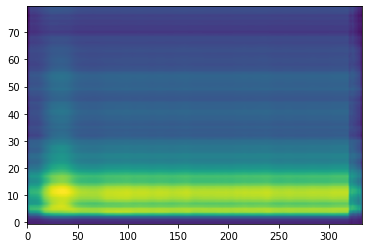

In [13]:
imshow(spectrogram, origin="lower", aspect = "auto")
plt.show()

In [14]:
ipd.display(ipd.Audio(audio, rate=22050))

In [14]:
for batch in spec_gen.train_dataloader():
    parsed = batch[4]
    print(parsed)
    break

tensor([[[9.4565e-01, 5.1959e-02, 2.3093e-03, 7.7841e-05, 1.7691e-06],
         [8.9369e-01, 9.9299e-02, 6.6943e-03, 3.0429e-04, 8.7439e-06],
         [8.4404e-01, 1.4225e-01, 1.2932e-02, 7.4323e-04, 2.5927e-05],
         [7.9663e-01, 1.8105e-01, 2.0810e-02, 1.4519e-03, 5.9784e-05],
         [7.5136e-01, 2.1591e-01, 3.0127e-02, 2.4810e-03, 1.1814e-04],
         [7.0818e-01, 2.4704e-01, 4.0689e-02, 3.8751e-03, 2.1010e-04],
         [6.6701e-01, 2.7465e-01, 5.2314e-02, 5.6726e-03, 3.4589e-04],
         [6.2777e-01, 2.9894e-01, 6.4830e-02, 7.9061e-03, 5.3683e-04],
         [5.9040e-01, 3.2010e-01, 7.8073e-02, 1.0602e-02, 7.9519e-04],
         [5.5484e-01, 3.3832e-01, 9.1888e-02, 1.3783e-02, 1.1341e-03],
         [5.2101e-01, 3.5377e-01, 1.0613e-01, 1.7465e-02, 1.5673e-03],
         [4.8885e-01, 3.6663e-01, 1.2066e-01, 2.1658e-02, 2.1095e-03],
         [4.5829e-01, 3.7708e-01, 1.3536e-01, 2.6369e-02, 2.7757e-03],
         [4.2929e-01, 3.8526e-01, 1.5010e-01, 3.1600e-02, 3.5813e-03],
      

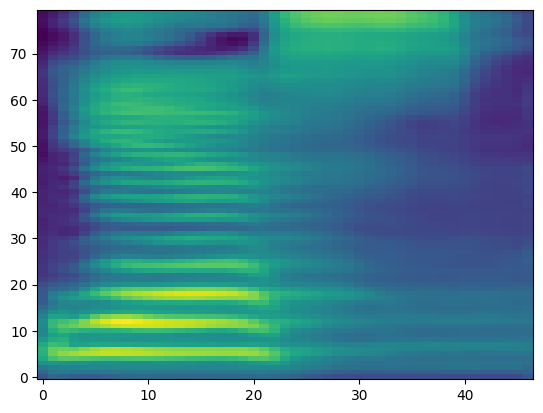

In [8]:
spectrogram = spec_gen.generate_spectrogram(tokens=parsed.cuda(), speaker=0)

imshow(spectrogram.cpu().detach().numpy()[0], origin="lower", aspect = "auto")

plt.show()

In [53]:
target = asr_model._wer.ctc_decoder_predictions_tensor(
        ids, predictions_len=len(, return_hypotheses=False,
    )

print(target)

IndexError: invalid index of a 0-dim tensor. Use `tensor.item()` in Python or `tensor.item<T>()` in C++ to convert a 0-dim tensor to a number

In [46]:
spec_gen.fastpitch.encoder(input=torch.tensor(['Hello']), conditioning=0)

ValueError: too many dimensions 'str'

In [9]:
audio = torch.tensor([[[1, 2, 3, 4, 0, 0]]])
audio_pred = torch.tensor([[[3, 5, 3, 4, 5]]])

audio_pred_ = torch.zeros_like(audio)
audio_pred_[:,:,:audio_pred[:audio.shape[-1]].shape[-1]] = audio_pred[:,:,:audio.shape[-1]]

audio_pred_

tensor([[[3, 5, 3, 4, 5, 0]]])

In [3]:
import os
import nemo
os.path.dirname(nemo.__file__)

'/home/boris/anaconda3/lib/python3.7/site-packages/nemo'